# Setting up the Notebook
---

This notebook aims to introduce the Kato2015 dataset, from [*Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans*](https://doi.org/10.1016/j.cell.2015.09.034), written by Kato *et al*.
We will detail how the raw data is organized and preprocessed.

*This notebook was written by Leandro Risso Venâncio (lrvenan@mit.edu). Last update: 17 Mai 2023*

In [1]:
#TODO: update this notebook

import mat73
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from preprocess._utils import interpolate_data, smooth_data_preprocess, reshape_calcium_data
import torch
from tests.leandro.plots import *

ROOT_DIR = '/home/lrvnc/Projects/worm-graph/'
DATA_DIR = os.path.join(ROOT_DIR, 'opensource_data/Kato2015/')
np.random.seed(42)

In [2]:
# Function to print n elements of a list
def print_list(l, n):
    for i in range(n):
        print(l[i])

# Function to pick non-none element from a list
def pick_non_none(l):
    for i in range(len(l)):
        if l[i] is not None:
            return l[i]
        
# Function to determine the similarity between two neurons
def neuron_similarity(neuron1, neuron2):
    neuron1 = neuron1.detach().numpy()
    neuron2 = neuron2.detach().numpy()
    return np.sum(neuron1.T @ neuron2) / (np.linalg.norm(neuron1) * np.linalg.norm(neuron2))


# Raw data structure
---

This dataset is splitted into two matlab documents: WT_Stim.mat and WT_NoStim.mat. Here is how they are sctructured:

* traces_raw= neural activity traces uncorrected
* traces = neural activity traces corrected for bleaching
* tracesDif = derivative of traces
* IDs = identified neuron IDs
* timeVectorSeconds = time vector in seconds
* fps = frames per second
* dataset = name of dataset
* stimulus
	* identity = what was changed e.g. O2 (oxygen)
	* type = stimulus type e.g. binary steps
	* switchtimes =  time in seconds when stimulus changed from initial state to the other state
	* initialstate = the state that the stimulus starts with, refers to "conc"
	* conc = the concentrations of the stimulus
	* concunits - units of the "conc"

States = vector of different state types (8 states for WT_NoStim, 4 states for WT_Stim and AVA_HisCl)

* 8 states for WT_NoStim:
	* ‘FWD’ forward crawling 
	* ‘SLOW’ forward slowing
	* ‘DT’ dorsal post reversal turn
	* ‘VT’ ventral post reversal turn
	* ‘REV1’ reverse crawling
	* ‘REV2’ reverse crawling
	* ‘REVSUS’ sustained reverse crawling
	* ‘NOSTATE’ - ambiguous
  
* 4 states for WT_Stim and AVA_HisCl:
	* ‘FWD’ forward crawling 
	* ‘REV’ reverse crawling
	* ‘REVSUS’ sustained reverse crawling
	* ‘TURN’ post reversal turn

# Processing the data
---

In [3]:
# Loading the data
dataset_raw = mat73.loadmat(DATA_DIR+'WT_Stim.mat')["WT_Stim"] # Return a dict
print('Raw data keys:', dataset_raw.keys(), end='\n\n')

# We will use just these features
features = ['IDs', 'traces', 'timeVectorSeconds']
sizes = {}
for ft in features:
    sizes[ft] = [len(data) for data in dataset_raw[ft]]
print('The features have the following sizes:')
for ft in features:
    print(' {}: {}'.format(ft, sizes[ft]))

Raw data keys: dict_keys(['IDs', 'States', 'dataset', 'fps', 'stimulus', 'timeVectorSeconds', 'traces', 'tracesDif', 'traces_raw'])

The features have the following sizes:
 IDs: [107, 122, 124, 134, 123, 151, 146]
 traces: [2198, 2017, 2197, 2018, 2201, 2017, 2019]
 timeVectorSeconds: [2198, 2017, 2197, 2018, 2201, 2017, 2019]


## Processing the neuron IDs
---

In [4]:
# Let's take a look at each the IDs
print_list(dataset_raw['IDs'], 2)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ['IL1DR', 'URYDR'], None, None, None, None, ['IL1DL', 'URYDL'], ['OLQDR', 'URYDR'], ['OLQVR', 'URYVR'], ['OLQVL', 'URYVL'], ['OLQDL', 'URYDL'], None, None, ['BAGL'], ['BAGR'], ['RMED'], ['RMEL'], None, None, ['RID'], None, None, ['RMEV'], ['ASKR'], [None, 'AFDL', 'ASKL'], ['AVAL'], None, ['ASKL', 'AFDL'], ['URXL', 'URXR'], ['ALA'], None, None, None, None, ['AVEL'], None, None, None, None, None, None, None, ['RIVL', 'AVHL', 'AVJL'], ['AIBR'], None, ['AVBL'], ['AIBL'], None, ['RIMR'], None, None, None, ['RIBL'], None, None, ['RIBR'], None, ['SMBDR', None], ['RIML'], None, None, None, None, None, None, None, None, None, None, None, ['RIS'], ['VB02'], None, ['AVFR'], ['SABVL', 'SABVR'], ['AVFL'], ['SABVR', None], ['RIFR'], None, ['VB01'], None, [None, 'RIGR'], ['SABD'], ['VA01'], ['RIGL'], None, ['SMDVL'], None, ['AVAR'], ['AVBR'], ['DB01'], ['DB02']]
[None, None, None, None, None, None, None, 

In [11]:
# Each list represents a worm. We need to extract just the neurons that are actives.
# Here we exemplify for the 5th worm.

oneID = dataset_raw['IDs'][4]
print('Raw IDs ({}): {}'.format(len(oneID), oneID))
oneID = [(pick_non_none(j) if isinstance(j, list) else j) for j in oneID] # Just the first active neuron
oneID = [
            (str(_) if j is None or isinstance(j, np.ndarray) else str(j))
            for _, j in enumerate(oneID)
        ] # Position on the list or name of the neuron
print('None to position ({}): {}'.format(len(oneID), oneID))
_, inds = np.unique(
            oneID, return_index=True
        )  # Get unique neurons and their indices
oneID = [oneID[i] for i in inds] # Get unique neurons
print('Unique neurons ({}): {}'.format(len(oneID), oneID))

Raw IDs (123): [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ['URYDR'], ['URYVL'], ['URYVR'], ['URADL'], ['URADR'], ['URYDL'], None, None, None, ['BAGL'], ['OLQVR'], None, None, ['OLQDL', 'URYDL'], ['OLQVL', 'URYVL'], ['OLQDR', 'URYDR'], ['BAGR'], ['RMER'], ['RMEL'], ['RMED'], None, ['RMEV'], None, None, ['RID'], None, ['AVAL'], None, ['---'], ['RMDVL'], ['---'], ['---', '---'], ['AVAR'], ['SMDVR'], ['ALA'], ['AVEL'], None, None, None, None, ['AVER'], ['URXL', 'URXR'], None, None, None, None, None, None, None, None, ['AIBL'], ['AIBR'], None, None, ['RIBL'], None, None, None, None, ['SIADR', None, '---'], None, ['AVBR'], ['AVBL'], None, None, ['RIBR'], None, None, None, None, None, ['RIMR'], ['RIVR', '---', '---'], None, None, None, None, None, ['RIML'], ['SMBDL'], None, None, None, ['SMBDR'], None, None, None, None, None, None, None, None, None, None, None, None, ['RIS'], None, None, ['VB02'], ['AVFR'], ['SABVR', 'SABVL'], ['AVFL

# Mapping the neurons
---

In [12]:
# Here is how we map the neurons to indices
neuron_to_idx = {
            nid: (str(nid) if (j is None or isinstance(j, np.ndarray)) else str(j))
            for nid, j in enumerate(oneID)
        }

print(neuron_to_idx)

{0: '---', 1: '0', 2: '1', 3: '10', 4: '101', 5: '102', 6: '103', 7: '104', 8: '105', 9: '106', 10: '107', 11: '108', 12: '109', 13: '11', 14: '110', 15: '111', 16: '112', 17: '114', 18: '115', 19: '12', 20: '13', 21: '14', 22: '15', 23: '16', 24: '2', 25: '23', 26: '24', 27: '25', 28: '28', 29: '29', 30: '3', 31: '37', 32: '39', 33: '4', 34: '40', 35: '42', 36: '44', 37: '5', 38: '53', 39: '54', 40: '55', 41: '56', 42: '59', 43: '6', 44: '60', 45: '61', 46: '62', 47: '63', 48: '64', 49: '65', 50: '66', 51: '69', 52: '7', 53: '70', 54: '72', 55: '73', 56: '74', 57: '75', 58: '77', 59: '8', 60: '80', 61: '81', 62: '83', 63: '84', 64: '85', 65: '86', 66: '87', 67: '9', 68: '90', 69: '91', 70: '92', 71: '93', 72: '94', 73: '97', 74: '98', 75: '99', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB02', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 9

In [13]:
# Format the neuron names if it finishes with 0
neuron_to_idx = {
            nid: (
                name.replace("0", "")
                if not name.endswith("0") and not name.isnumeric()
                else name
            )
            for nid, name in neuron_to_idx.items()
        }
print(neuron_to_idx)

{0: '---', 1: '0', 2: '1', 3: '10', 4: '101', 5: '102', 6: '103', 7: '104', 8: '105', 9: '106', 10: '107', 11: '108', 12: '109', 13: '11', 14: '110', 15: '111', 16: '112', 17: '114', 18: '115', 19: '12', 20: '13', 21: '14', 22: '15', 23: '16', 24: '2', 25: '23', 26: '24', 27: '25', 28: '28', 29: '29', 30: '3', 31: '37', 32: '39', 33: '4', 34: '40', 35: '42', 36: '44', 37: '5', 38: '53', 39: '54', 40: '55', 41: '56', 42: '59', 43: '6', 44: '60', 45: '61', 46: '62', 47: '63', 48: '64', 49: '65', 50: '66', 51: '69', 52: '7', 53: '70', 54: '72', 55: '73', 56: '74', 57: '75', 58: '77', 59: '8', 60: '80', 61: '81', 62: '83', 63: '84', 64: '85', 65: '86', 66: '87', 67: '9', 68: '90', 69: '91', 70: '92', 71: '93', 72: '94', 73: '97', 74: '98', 75: '99', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB2', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 96

In [14]:
# Invert the mapping
neuron_to_idx = dict(
    (v, k) for k, v in neuron_to_idx.items()
)

# Processing the Data and Time
---

In [15]:
# Reshape it to a column vector
oneTime = dataset_raw['timeVectorSeconds'][4]
oneTime = oneTime.reshape(-1, 1)
print('Time vector: {}'.format(oneTime.shape))

Time vector: (2201, 1)


In [16]:
# Using just the unique neurons, we can extract the traces
oneTrace = dataset_raw['traces'][4]
oneTrace = oneTrace[:, inds]
print('Unique traces: {}'.format(oneTrace.shape))

Unique traces: (2201, 121)


In [17]:
# Number of neurons with name
num_named = len([i for i in oneID if not i.isnumeric()])
print('Number of named neurons: {}'.format(num_named))

Number of named neurons: 46


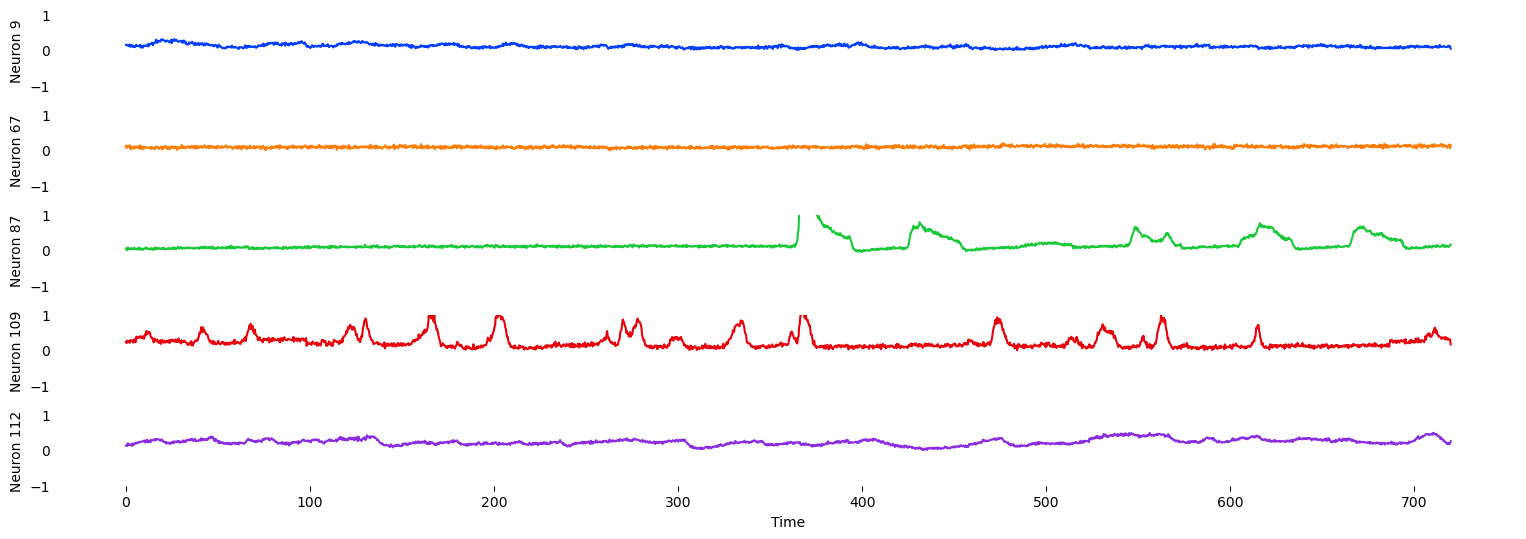

In [18]:
# Let's plot the raw traces
plot_signals(torch.from_numpy(oneTrace), torch.from_numpy(oneTime), [9, 67, 87, 109, 112])

In [19]:
# We can choose to normalize the traces in the time dimension or in the feature dimension
transform = MinMaxScaler(feature_range=(-1, 1))

oneTrace_norm_ft = transform.fit_transform(oneTrace) # Normalize in the feature dimension

oneTrace_norm_tm = transform.fit_transform(oneTrace.T).T # Normalize in the time dimension

In [20]:
oneTime = torch.from_numpy(oneTime).float()
oneTrace = torch.from_numpy(oneTrace_norm_ft).float() # We will use the feature normalized traces in this example

Time step difference: [0.1 0.1 0.1 ... 0.1 0.1 0.1]


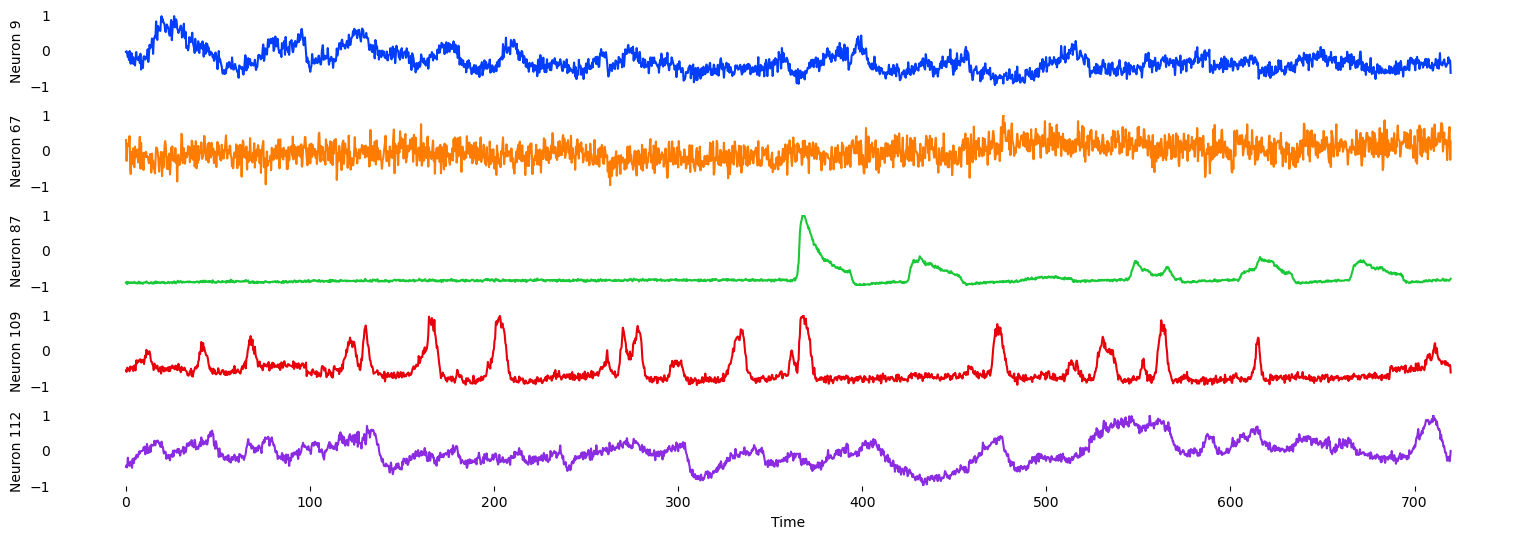

Time vector: (7197,)
Unique traces: (7197, 121)


In [26]:
# Now we need to resample the signal to a fixed time step
oneTime_interp, oneTrace_interp = interpolate_data(oneTime, oneTrace, target_dt=0.1)

# Print difference between consecutive time steps of oneTime
print('Time step difference: {}'.format(np.diff(oneTime_interp.flatten())))

# Let's plot the resampled traces
plot_signals(torch.from_numpy(oneTrace_interp), torch.from_numpy(oneTime_interp), [9, 67, 87, 109, 112])

print('Time vector: {}'.format(oneTime_interp.shape))
print('Unique traces: {}'.format(oneTrace_interp.shape))

At this point, we can't compare the similarity using a measurable quantity, because the signals don't have the same dimension.

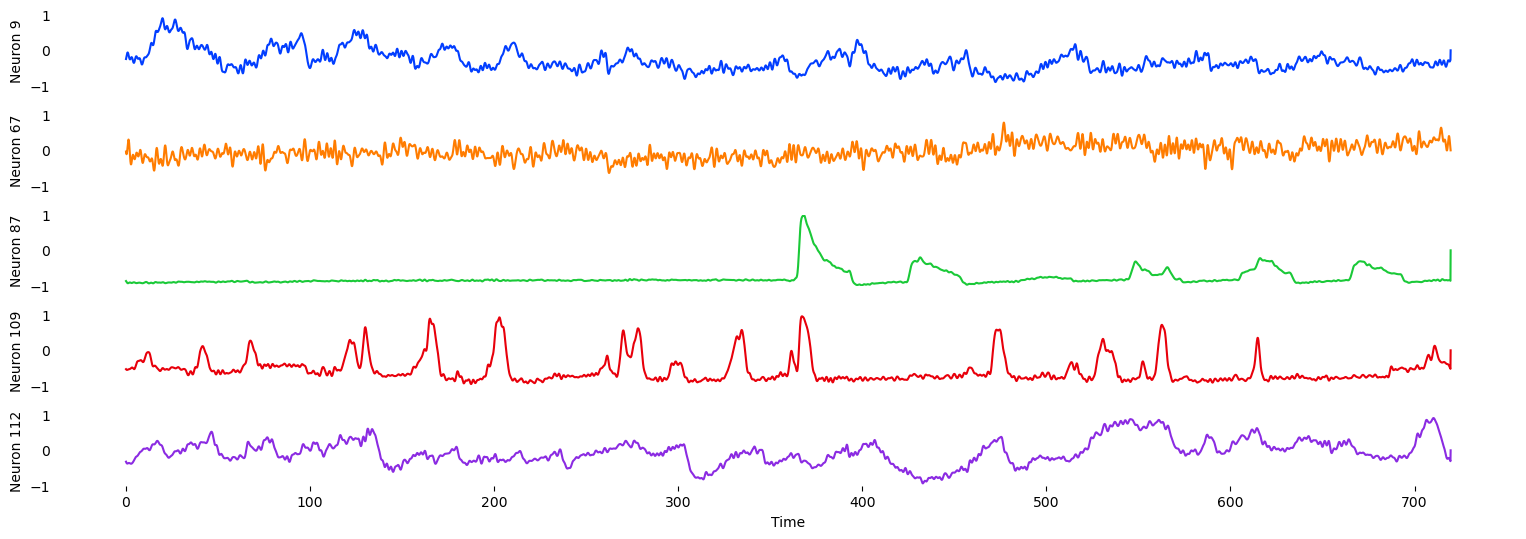

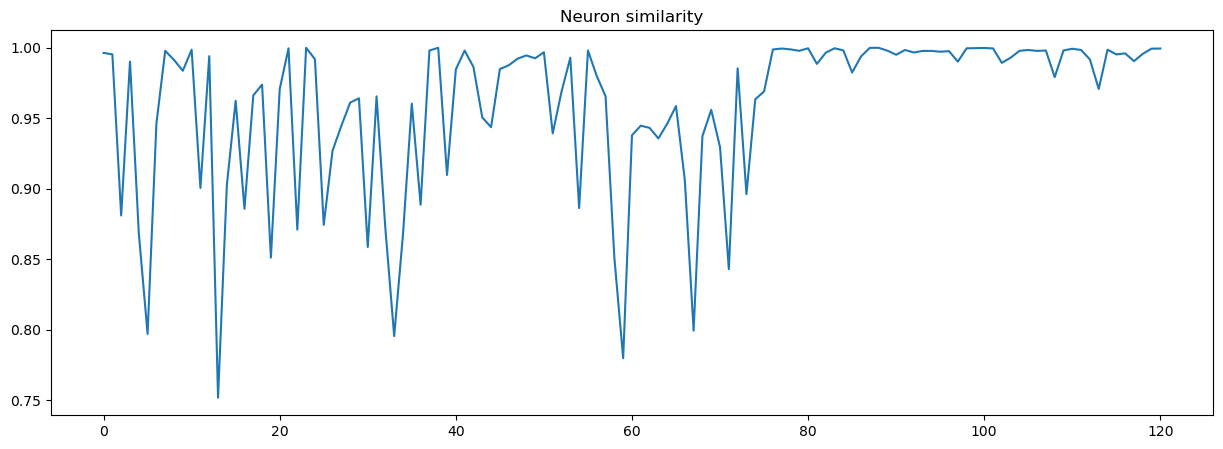

In [32]:
# Let's smooth the data using the FFT method
oneTrace_smooth = smooth_data_preprocess(oneTrace_interp, smooth_method='fft', time_in_seconds=oneTime_interp)

# Let's plot the smoothed traces
plot_signals(torch.from_numpy(oneTrace_smooth), torch.from_numpy(oneTime_interp), [9, 67, 87, 109, 112])

# Let's see the similarity between the neurons (columns)
sim = []
for n in range(oneTrace_smooth.shape[1]):
    sim.append(neuron_similarity(torch.from_numpy(oneTrace_smooth[:, n]), torch.from_numpy(oneTrace_interp[:, n])))

plt.figure(figsize=(15, 5))
plt.plot(sim)
plt.title('Neuron similarity')
plt.show()

In [33]:
# Finally we need to reshape the data to a standard format
# First we save all the data inside a data dict to pass to the function

oneDict = {}

oneDict.update(
    {
        "worm0": {
            "dataset": "Kato2015",
            "smooth_method": "FFT",
            "worm": "worm0",
            "calcium_data": oneTrace_interp,
            "smooth_calcium_data": oneTrace_smooth,
            #! "residual_calcium": res,
            #! "smooth_residual_calcium": res_smooth,
            "neuron_to_idx": neuron_to_idx,
            "idx_to_neuron": dict((v, k) for k, v in neuron_to_idx.items()),
            "max_timesteps": oneTrace_interp.shape[0],
            "time_in_seconds": oneTime_interp,
            "dt": .10,
            "num_neurons": oneTrace_interp.shape[1],
            "num_named_neurons": num_named,
            "num_unknown_neurons": oneTrace_interp.shape[1] - num_named,
        },
    }
)

In [34]:
# Now we can call the function to reshape the data
oneDict_std = reshape_calcium_data(oneDict['worm0'])

# Here are the keys of the final dict
print(oneDict_std.keys())

KeyError: 'residual_calcium'

In [39]:
for key in oneDict_std.keys():
    if type(oneDict_std[key]) is str:
        print('{}: {}'.format(key, oneDict_std[key]))
    elif (type(oneDict_std[key]) is float) or (type(oneDict_std[key]) is int):
        print('{}: {}'.format(key, oneDict_std[key]))
    elif (type(oneDict_std[key]) is dict):
        print('{}: {}'.format(key, len(oneDict_std[key])))
    else:
        print('{}: {}'.format(key, oneDict_std[key].shape))

dataset: Kato2015
smooth_method: FFT
worm: worm0
calcium_data: torch.Size([7197, 302])
smooth_calcium_data: torch.Size([7197, 302])
residual_calcium: torch.Size([7197, 302])
smooth_residual_calcium: torch.Size([7197, 302])
max_timesteps: 7197
time_in_seconds: torch.Size([7197, 1])
dt: 0.1
num_neurons: 121
num_named_neurons: 46
num_unknown_neurons: 75
named_neurons_mask: torch.Size([302])
unknown_neurons_mask: torch.Size([302])
neurons_mask: torch.Size([302])
slot_to_named_neuron: 302
named_neuron_to_slot: 302
slot_to_unknown_neuron: 75
unknown_neuron_to_slot: 75
slot_to_neuron: 302
neuron_to_slot: 302


* `dataset`: (str) Name of the dataset
* `smooth_method`: (str) Method used to smooth the calcium data
* `worm`: (str) The worm ID in the dataset
* `max_timesteps`: (float) Number of time steps of the data
* `dt`: (float) Difference between time steps
* `calcium_data`: (torch.tensor) The calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `smooth_calcium_data`: (torch.tensor) Smoothed calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `residual_calcium`: (torch.tensor) The residual calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `smooth_residual_calcium`: (torch.tensor) Smoothed residual calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `time_in_seconds`: (torch.tensor) A column vector equally spaced by `dt`. Shape: (`max_timesteps`, 1)
* `num_neurons`: (int) Number of total tracked neurons of this specific worm
* `num_named_neurons`: (int) Number of labeled neurons
* `num_unknown_neurons`: (int) Number of unlabeled neurons
* `named_neurons_mask`: (torch.tensor) A bool vector indicating the positions of the labeled neurons. Shape: (302)
* `unknown_neurons_mask`: (torch.tensor) A bool vector indicating the positions of the unlabeled neurons. Shape: (302)
* `neurons_mask`: (torch.tensor) A bool vector indication the positions of all tracked neurons (labeled + unlabeled). Shape: (302)
* `slot_to_named_neuron`: (dict) Mapping of column index -> 302 neurons. Len: `num_neurons`
* `named_neuron_to_slot`: (dict) Mapping of 302 neurons -> column index. Len: `num_neurons`
* `slot_to_unknown_neuron`: (dict) Mapping of column index -> unlabeled neuron. Len: `num_unknown_neurons`
* `unknown_neuron_to_slot`: (dict) Mapping of unlabeled neurons -> column index. Len: `num_unknown_neurons`
* `slot_to_neuron`: (dict) Mapping of column intex -> labeled+unlabeled neurons. Len: `num_neurons`
* `neuron_to_slot`: (dict) Mapping of labeled+unlabeled neurons -> column index. Len: `num_neurons`